# EDA On SQuAD v1.1 and v2.0

This week I'll be performing exploratory data analysis on the Stanford Question-Answer Dataset (SQuAD), both version 1.1 and 2.0 to identify the improvements made upon the dataset since its inception. At the end I hope to learn trends in the dataset, notice the changes the researchers made since the original version, and understand what tasks this type of dataset is preparing a model for. 

**(Note: Most of the code in this report is not essential to understanding the results - still I include text before most code blocks explaining what I'm doing. If you're interested in how I am manipulating the data feel free to examine the code closely, but otherwise it's not important!)**

## Downloading the datasets

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

ds1, info1 = tfds.load("squad/v1.1", split = 'train', with_info = True) # training dataset for v1.1
ds2, info2 = tfds.load("squad/v2.0", split = 'train', with_info = True) # training dataset for v2.0

## Information about SQuAD

The `info1` and `info2` objects contain a lot of information about each dataset, such as publication date, publisher, descriptions, copyright information, and information about the datasets themselves. We'll use it to take a peek at a few things:

First let's see the description provided with the datasets, the descriptions are identical for each version:

In [7]:
print('Description of SQuAD: ', info1.description)

Description of SQuAD:  Stanford Question Answering Dataset (SQuAD) is a reading comprehension dataset,
consisting of questions posed by crowdworkers on a set of Wikipedia articles,
where the answer to every question is a segment of text, or span, from the
corresponding reading passage, or the question might be unanswerable.


The above gives us some idea on how the datasets were originally collected and the type of downstream task it would be used to train / test for. 

The next element of info, `info.features`, will show us the structure of individual elements in the datasets: 

In [12]:
info1.features

FeaturesDict({
    'answers': Sequence({
        'answer_start': int32,
        'text': Text(shape=(), dtype=string),
    }),
    'context': Text(shape=(), dtype=string),
    'id': string,
    'question': Text(shape=(), dtype=string),
    'title': Text(shape=(), dtype=string),
})

In [10]:
info2.features

FeaturesDict({
    'answers': Sequence({
        'answer_start': int32,
        'text': Text(shape=(), dtype=string),
    }),
    'context': Text(shape=(), dtype=string),
    'id': string,
    'is_impossible': bool,
    'plausible_answers': Sequence({
        'answer_start': int32,
        'text': Text(shape=(), dtype=string),
    }),
    'question': Text(shape=(), dtype=string),
    'title': Text(shape=(), dtype=string),
})

So, v1.1 contains the answer start index, the text of the answer, `context`, `id`, the question, and the title. v2.0 contains all of that but some additional pieces of information, a boolean value titled `is_possible` and something called `plausible_answers`. 

With that, we know the structure of the dataset which is helpful, but we dont *really* know what all of those elements represent, although we can guess. 

Other than the obvious ones, 
* `context` might contain the strings around the answer 
* `id` is probably an integer identifier for each data point 
* `is_impossible` probably tracks whether or not the correct answer can actually be produced from the given information
* `plausible_answers` might contain good guesses at an answer or if a correct answer appears multiple times in a paragraph
* `title` is likely the title of the wikipedia page the paragraph and answer was sourced from

The last thing we'll check is `info.splits` which will give us information on the train/test/validation splits. 

In [16]:
info1.splits

{'train': <SplitInfo num_examples=87599, num_shards=1>,
 'validation': <SplitInfo num_examples=10570, num_shards=1>}

In [17]:
info2.splits

{Split('train'): <SplitInfo num_examples=130319, num_shards=2>,
 Split('validation'): <SplitInfo num_examples=11873, num_shards=1>}

So, v2.0 also has 44,000 more samples than v1.1 and we're only provided with training and validation splits. 

## Example data points

Now that we have a bit of background, let's compare one example from each dataset and then we can see how to proceed with finding any type of aggregate information

Here's a data point from v1.1:

In [57]:
for ex1 in ds1:
  print('Title: ', ex1['title'].numpy().decode())
  print('id: ', ex1['id'].numpy().decode())
  print('Question: ', ex1['question'].numpy().decode())
  print('Context: ', ex1['context'].numpy().decode()[:100], '...')
  print('Answer start: ', ex1['answers']['answer_start'].numpy()[0])
  print('Answer text: ', ex1['answers']['text'].numpy()[0].decode())
  break


Title:  Antenna_(radio)
id:  57306bf68ab72b1400f9c4dc
Question:  What is one use that would require an antenna to receive signals in various ways at once?
Context:  The difference in the above factors for the case of θ=0 is the reason that most broadcasting (transm ...
Answer start:  427
Answer text:  mobile phones


First, let's verify that all the variables of each data point represent what we think they do:

From the wikipedia page for [Antenna (radio)](https://en.wikipedia.org/wiki/Antenna_(radio)) and searching the first few words of the string stored in `context` we can find the following quote:

> "The difference in the above factors for the case of θ = 0 is the reason that most broadcasting (transmissions intended for the public) uses vertical polarization. For receivers near the ground, horizontally polarized transmissions suffer cancellation. For best reception the receiving antennas for these signals are likewise vertically polarized. In some applications where the receiving antenna must work in any position, as in mobile phones, the base station antennas use mixed polarization, such as linear polarization at an angle (with both vertical and horizontal components) or circular polarization."

So, indeed `Title` is the title of the wikipedia page the answer / question come from. 

In this we can also see `context` is the paragraph containing our answer, so there's another one out of the way. 

The last thing to check is what the integer `answer_start` represents, it's likely just the index of the first character of our answer, let's check:

In [58]:
ex1['context'].numpy().decode()[427:440]

'mobile phones'

Perfect, that all makes sense and lines up with what we thought! Let's look at an example from v2.0:

In [74]:
for ex2 in ds2:
  print('Title: ', ex2['title'].numpy().decode())
  print('id: ', ex2['id'].numpy().decode())
  print('Question: ', ex2['question'].numpy().decode())
  print('Context: ', ex2['context'].numpy().decode()[:100], '...')
  print('Impossible?: ', ex2['is_impossible'].numpy())
  print('Answer start: ', ex2['answers']['answer_start'].numpy())
  print('Answer text: ', ex2['answers']['text'].numpy())
  print('Plausible answer start: ', ex2['plausible_answers']['answer_start'][0].numpy())
  print('Answer text: ', ex2['plausible_answers']['text'].numpy()[0].decode())
  break

Title:  Zinc
id:  5acfc8c277cf76001a685f6e
Question:  What is the danger of zinc after injury?
Context:  Zinc is included in most single tablet over-the-counter daily vitamin and mineral supplements. Prepa ...
Impossible?:  True
Answer start:  []
Answer text:  []
Plausible answer start:  349
Answer text:  speed up the healing


Interesting! The first example we can observe is actually impossible to answer which explains why there's no index or string associated with the answer idx / text variables. 

There is, however, a plausible answer - it's not correct because speeding up healing is not a dangerous property of zinc (I don't think). An interesting question arises when training a model on w2.0, how is it scored if the model produced a plausible answer instead of the correct answer? Does this encourage a model to produce plausible answers if none exist? I suppose it's probably up to the architect of the model, but still interseting to consider the different ways that it could be handled. 

Quickly, let's find an example with an actual answer and see whether or not it will have plausible answers:

In [78]:

for ex2 in ds2:
  if ex2['is_impossible'].numpy() == False:
    print('Title: ', ex2['title'].numpy().decode())
    print('id: ', ex2['id'].numpy().decode())
    print('Question: ', ex2['question'].numpy().decode())
    print('Context: ', ex2['context'].numpy().decode()[:100], '...')
    print('Impossible?: ', ex2['is_impossible'].numpy())
    print('Answer start: ', ex2['answers']['answer_start'][0].numpy())
    print('Answer text: ', ex2['answers']['text'][0].numpy().decode())
    print('Plausible answer start: ', ex2['plausible_answers']['answer_start'].numpy())
    print('Answer text: ', ex2['plausible_answers']['text'].numpy())
    break

Title:  Antenna_(radio)
id:  57306bf68ab72b1400f9c4dc
Question:  What is one use that would require an antenna to receive signals in various ways at once?
Context:  The difference in the above factors for the case of θ=0 is the reason that most broadcasting (transm ...
Impossible?:  False
Answer start:  427
Answer text:  mobile phones
Plausible answer start:  []
Answer text:  []


Okay! So, it appears that if a question has an answer, it will not have a plausible answer, and vice versa! Lastly, since this example seems to be the same question as the example in v1.1, let's see if the id has changed at all:

In [80]:
ex2['id'].numpy().decode() == ex1['id'].numpy().decode()

True

It turns out the id did not change at all! A sign that the researchers likely utilized data from v1.1 that they already labeled. 

## Collecting data

The properties I'm interested in:
* Distribution of answer start index across both versions
* Length of answer across both versions
* Length of context across both versions
* Number of unanswerable questions in v2.0
* Start index for answer vs plausible in v2.0
* Answer length vs Plausible answer length
* Context length for answerable vs unanswerable questions

In the following collection of cells I am 
* downloading the validation datasets (only have training data right now)
* initializing variables to store all the information we want
* iterating through each dataset and 
  * accumulating the desired information into lists

Another thing to note was while doing this, I ran into a data point that was a bit interesting, so I saved the id in `noanswerid` to retrieve while rerunning the code and save the data point to talk about later!

In [ ]:
ds1_val = tfds.load("squad/v1.1", split = 'validation') # validation dataset for v1.1 
ds2_val = tfds.load("squad/v2.0", split = 'validation') # validation dataset for v2.0

In [110]:
v1_astart = []
v1_alen = []
v1_qlen = []
v1_clen = []

v2_astart = []
v2_alen = []
v2_pstart = []
v2_plen = []
v2_qlen = []
v2_possible_clen = []
v2_impossible_clen = []

noanswerid = '5ad26000d7d075001a428fb0'

In [111]:
for data in ds1: 
  v1_astart.append(data['answers']['answer_start'].numpy()[0])
  v1_alen.append(len(data['answers']['text'].numpy()[0].decode()))
  v1_qlen.append(len(data['question'].numpy().decode()))
  v1_clen.append(len(data['context'].numpy().decode()))

In [112]:
for data in ds1_val: 
  v1_astart.append(data['answers']['answer_start'].numpy()[0])
  v1_alen.append(len(data['answers']['text'].numpy()[0].decode()))
  v1_qlen.append(len(data['question'].numpy().decode()))
  v1_clen.append(len(data['context'].numpy().decode()))

In [113]:
for data in ds2: 
  if data['is_impossible']:
    v2_pstart.append(data['plausible_answers']['answer_start'].numpy()[0])
    v2_plen.append(len(data['plausible_answers']['text'].numpy()[0].decode()))
    v2_qlen.append(len(data['question'].numpy().decode()))
    v2_impossible_clen.append(len(data['context'].numpy().decode()))
  else:  
    v2_astart.append(data['answers']['answer_start'].numpy()[0])
    v2_alen.append(len(data['answers']['text'].numpy()[0].decode()))
    v2_qlen.append(len(data['question'].numpy().decode()))
    v2_possible_clen.append(len(data['context'].numpy().decode()))

In [114]:
for data in ds2_val: 
  if data['id'].numpy().decode() == noanswerid:
    noanswer = data
  if data['is_impossible']:
    if data['plausible_answers']['text'].numpy().shape != (0,):
      v2_pstart.append(data['plausible_answers']['answer_start'].numpy()[0])
      v2_plen.append(len(data['plausible_answers']['text'].numpy()[0].decode()))
    v2_qlen.append(len(data['question'].numpy().decode()))
    v2_impossible_clen.append(len(data['context'].numpy().decode()))
  else:  
    v2_astart.append(data['answers']['answer_start'].numpy()[0])
    v2_alen.append(len(data['answers']['text'].numpy()[0].decode()))
    v2_qlen.append(len(data['question'].numpy().decode()))
    v2_possible_clen.append(len(data['context'].numpy().decode()))

## Analyzing data

First, let's examine the start index of the answers in both versions alongside the start index of the plausible answers. 

I originally started by producing a normal histogram but realized that because of the varying sizes of the datasets that the results were not easily interpretable - to solve this I switched the boolean parameter `density` in `plt.hist` to `True`. This plots the probabilities of our index being within a certain bucket rather than the counts. 

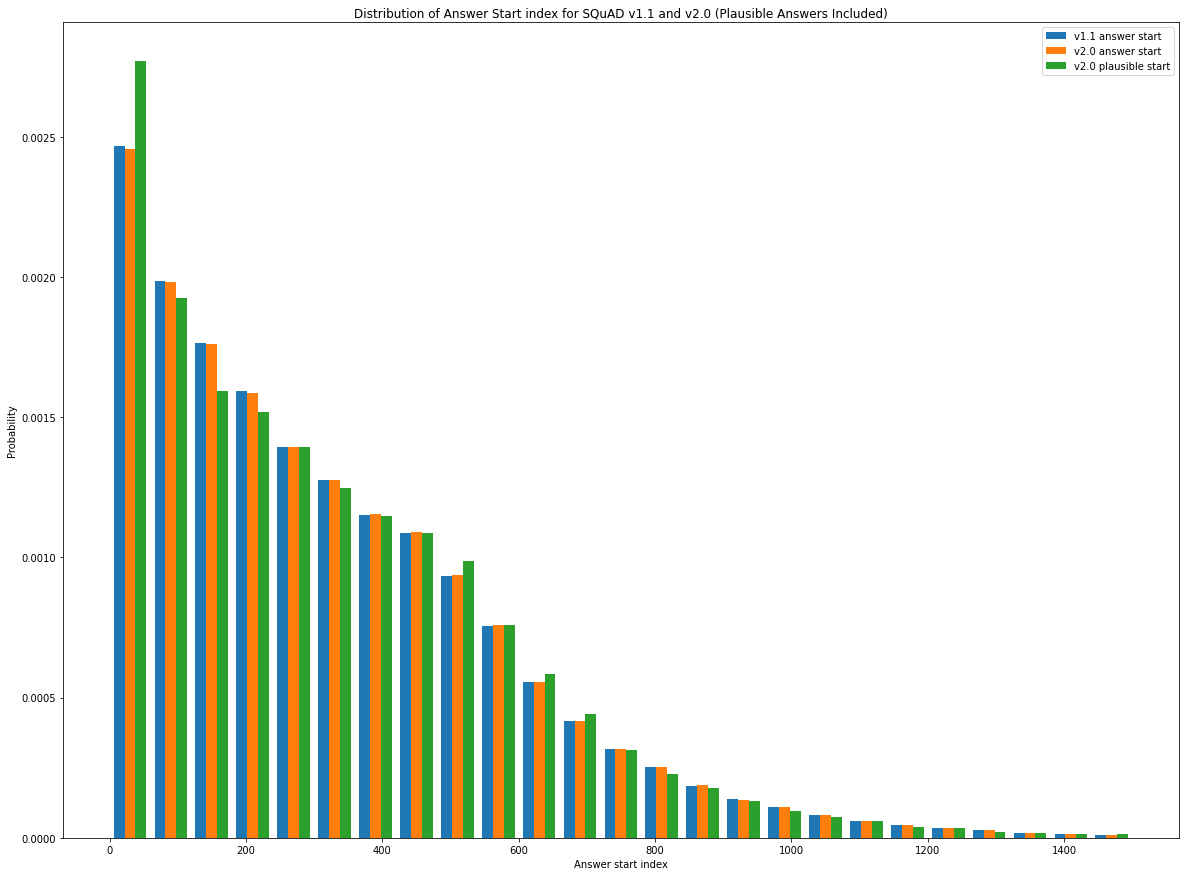

In [161]:
### plotting histogram for start index values

fig = plt.figure(figsize = (20,15))
plt.hist([v1_astart, v2_astart, v2_pstart], bins = 25, density = True, histtype='bar', label = ['v1.1 answer start', 'v2.0 answer start', 'v2.0 plausible start'], range = (0, 1500))
plt.legend()
plt.title('Distribution of Answer Start index for SQuAD v1.1 and v2.0 (Plausible Answers Included)')
plt.ylabel('Probability')
plt.xlabel('Answer start index')
plt.show()

Above we can see a few things

* Primarily, v1.1 and v2.0 have the same distribution of answer start values 
* Secondly, there may be a tendency for answers to occur earlier in paragraphs, but we'll have to do a bit more analysis to verify that. 

Now let's look at answer lengths using the same modification to `distribution`:

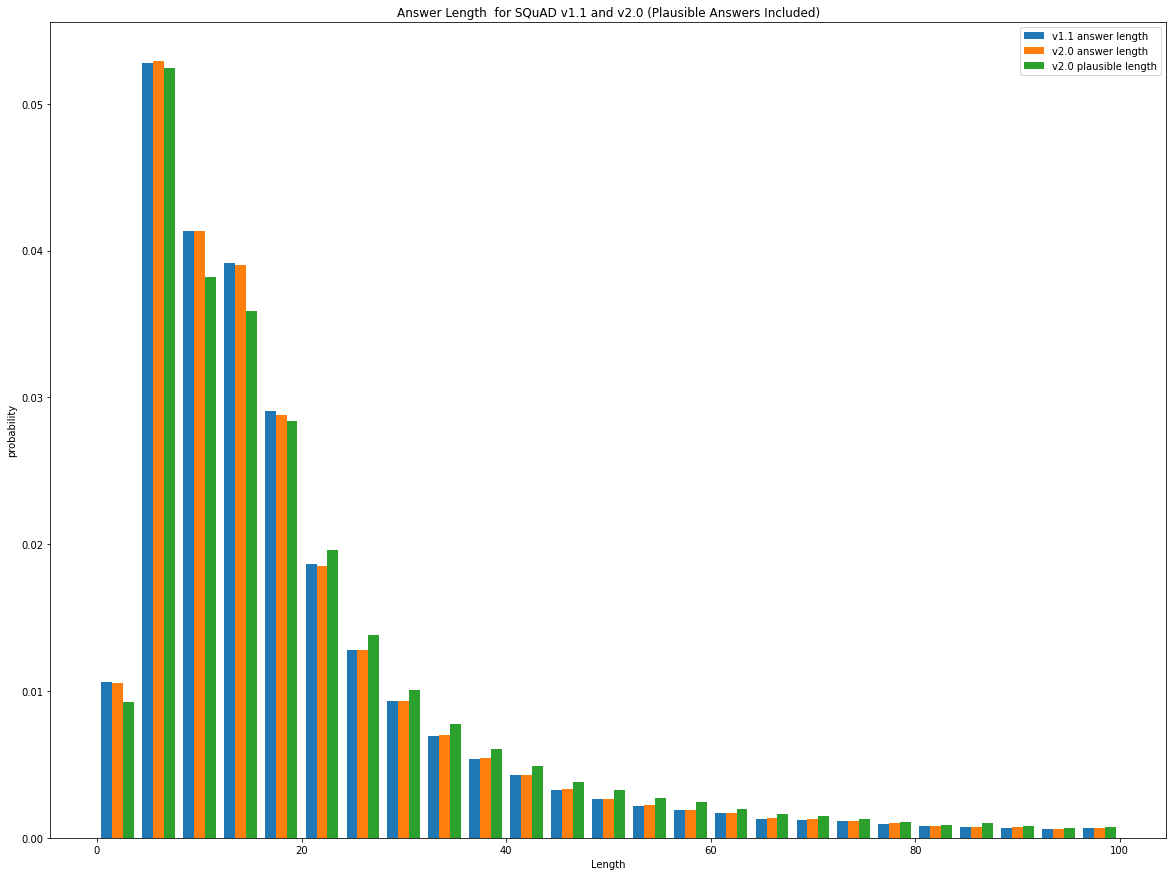

In [164]:
### plotting answer lengths

fig = plt.figure(figsize = (20,15))
plt.hist([v1_alen, v2_alen, v2_plen], density = True, bins = 25, histtype='bar', label = ['v1.1 answer length', 'v2.0 answer length', 'v2.0 plausible length'], range = (0, 100))
plt.legend()
plt.title('Answer Length  for SQuAD v1.1 and v2.0 (Plausible Answers Included)')
plt.ylabel('probability')
plt.xlabel('Length')
plt.show()

From this figure we get the same conclusion that the old and new datasets have highly similar distributions of answer lengths. The unique thing about this is that answer lengths typically are very close together - considering the smallest is a few characters and answers typically aren't larger than 50 characters which is only a couple words. 

Next I want to look at context lengths just to make sure there aren't any important ties to answer start indices:

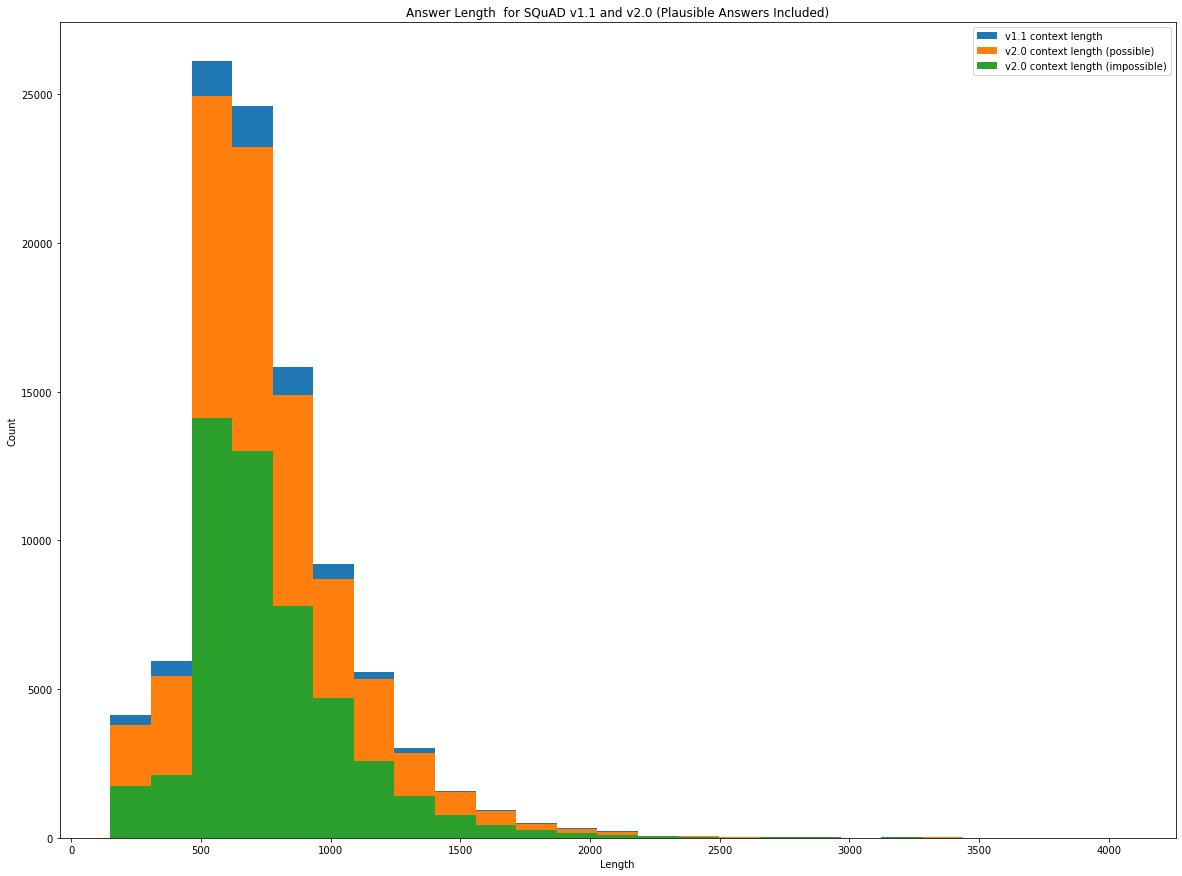

In [172]:
### plotting context lengths:

fig = plt.figure(figsize = (20,15))
plt.hist(v1_clen, bins = 25, histtype='bar', label = 'v1.1 context length')
plt.hist(v2_possible_clen, bins = 25, histtype='bar', label = 'v2.0 context length (possible)')
plt.hist(v2_impossible_clen, bins = 25, histtype='bar', label = 'v2.0 context length (impossible)')
plt.legend()
plt.title('Answer Length  for SQuAD v1.1 and v2.0 (Plausible Answers Included)')
plt.ylabel('Count')
plt.xlabel('Length')
plt.show()

For this figure I chose to plot the histograms as overlapping and without the modification to the `density` parameter because that type of interpretation would not assist us. Just note that the bars for v2.0 are below v1.0 simply because there are fewer total entries since we decided to look at samples with and without answers individually. 

What can we take away from this figure? Well, regardless of a sample being in v1.1 or v2.0 and regardless of whether or not a sample is possible or not, the context parargraphs follow nearly identical distributions. 

**Importantly, this means that whether or not an answer is inside a paragraph is likely not dependant upon how long a given paragraph is.**

Another thing to note is that context paragraphs tend not to be longer than 1500 characters, which would also explain why the start index of an answer tends to be lower. Knowing this I'd like to plot the context length vs. the answer start index to see if there really is a trend or if it's mainly because context paragraphs aren't that long. Since we've seen that v1.1 and v2.0 have similar distributions, we can confidently look at the plot just for sentences in v1.1 and generalize those conclusions.

In [182]:
clen = []
astart = []

for data in ds1_val:
  astart.append(data['answers']['answer_start'].numpy()[0])
  clen.append(len(data['context'].numpy().decode()))

Text(0.5, 1.0, 'Context Length vs. Answer Start Index')

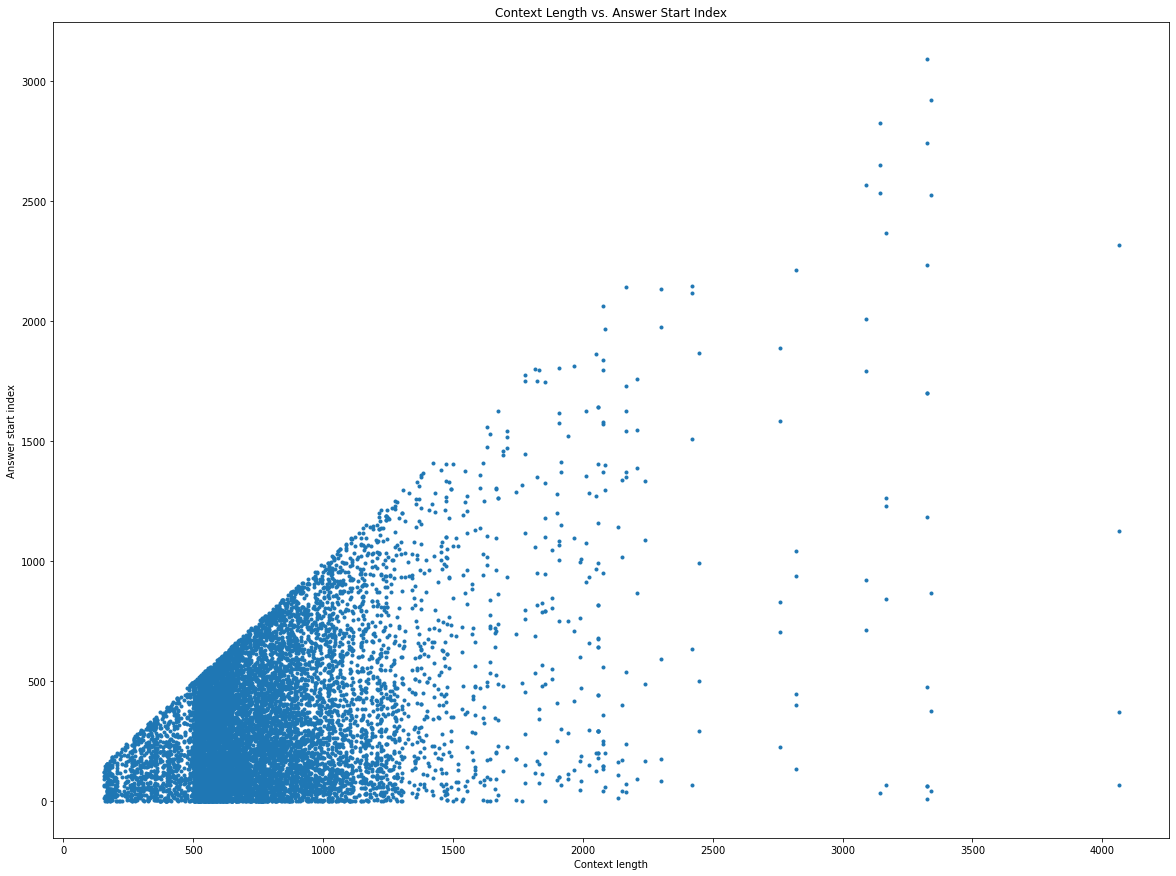

In [185]:
plt.figure(figsize = (20, 15))
plt.plot(clen, astart, '.')
plt.xlabel('Context length')
plt.ylabel('Answer start index')
plt.title('Context Length vs. Answer Start Index')

So it appears that our guess that answers tended to appear earlier in paragraphs is **FALSE**. If that were true, we would have a higher concentration of points in the lower half of our figure, but instead they're almost uniformly distributed from early indices to later indices in paragraphs of any length! 

#### Examining Unanswerable Questions

As the last part of our EDA, I'd like to briefly examine the unanswerable questions. The first thing to look at is exactly how many unanswerable questions there are:



In [175]:
print('Total number of unanswerable questions: ', len(v2_impossible_clen))

Total number of unanswerable questions:  49443


So a little over 1/3 of our data is unanswerable in the v2.0 dataset - a highly nontrivial amount!

In [178]:
print('Number of answerable questions in v2.0: ', len(v2_possible_clen))
print('Total number of questions in v1.1', len(v1_qlen))

Number of answerable questions in v2.0:  92749
Total number of questions in v1.1 98169


From the two numbers above we can see that the researchers did not simply add 50,000 unanswerable questions to the v1.1 dataset - otherwise they would have the same number of answerable questions - instead they actually chose to remove ~6000 samples that were present in the original version of the dataset. 

This puzzles me because unless they were poorl samples (i.e. high bias, incorrectly labeled, etc.) it seems like there would be no benefit to removing them. 

Lastly, let's examine the sample I isolated when parsing the dataset - I'll print all of it's information:

In [117]:
print('Title: ', noanswer['title'].numpy().decode())
print('id: ', noanswer['id'].numpy().decode())
print('Question: ', noanswer['question'].numpy().decode())
print('Context: ', noanswer['context'].numpy().decode()[:100], '...')
print('Impossible?: ', noanswer['is_impossible'].numpy())
print('Answer start: ', noanswer['answers']['answer_start'].numpy())
print('Answer text: ', noanswer['answers']['text'].numpy())
print('Plausible answer start: ', noanswer['plausible_answers']['answer_start'].numpy())
print('Answer text: ', noanswer['plausible_answers']['text'].numpy())

Title:  Oxygen
id:  5ad26000d7d075001a428fb0
Question:  In case of cabin pressurization, what is available to passengers?
Context:  People who climb mountains or fly in non-pressurized fixed-wing aircraft sometimes have supplemental ...
Impossible?:  True
Answer start:  []
Answer text:  []
Plausible answer start:  []
Answer text:  []


The thing to note about this data point is that while it does not have an answer, it also has no plausible answers in the paragraph. Oddly enough, I only ran into a data point like this in the validation dataset. Before we proceed let's find out how many such data points exist:

In [128]:
print("Number of entries with no answer OR plausible answer: ", len(v2_qlen) - (len(v2_alen) + len(v2_plen)))  ### total num. of samples - (samples with answers + samples with plausible answers)

Number of entries with no answer OR plausible answer:  15


To me this is pretty bizarre! We have 130,000 samples in the training dataset, *none* of which fall into this category. While we don't have a large amount of points without both an answer and potential answer, most models probably would not be able to learn that such a scenario exists! While that would yield only a fraction of a percentage of error it's still surprising to see such behavior.

This only makes me wonder, perhaps there are samples with both answers and plausible answers, so let's see if that's the case:



In [186]:
for ds in [ds2, ds2_val]:
  for data in ds: 
    if data['plausible_answers']['text'].numpy().shape != (0,) and data['answers']['text'].numpy().shape != (0,):
      print('At least 1 exists')
      break

Okay good, no such samples like that exist, so we don't have to redo any analysis with that in mind!

## Conclusions

SQuAD v1.1 and v2.0 are both very versatile datasets when training for contextual awareness tasks. This type of data is not emphasizing learning linguistic traits like word similarity, word representations, translation, etc. instead it's focused almost entirely on syntactic context, really reducing down to 'what's the most important part of this paragraph?'

Both versions of the dataset are very consistent with their behavior very closely resembling one another - the only real difference is the presence of plausible answers when a true answer does not exist. Like I briefly mentioned earlier, the implications of such a trait could mean a lot but I hypothesize that this is to allow a model to generalize to actual applications better. Rather than just fail if an answer does not exist, v2.0 will encourage a model to adapt and attempt under more rigorous circumstances. 

I can see why such a skill would be important in a model, and this type of dataset could be extended to general information extraction which is likely important in modern models like chatgpt where it needs to understand exactly what a user is requesting among a potentially large blurb of text and information. 